In [1]:
import sys, os, pickle
import pandas as pd
import numpy as np

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from create_datasets import create_nx_datasets
from create_datasets.create_table_datasets import load_data
from ml_models.machine_learning_models import create_class_LOAD
from ml_models.utils import boxplot_comparison_models, statistics, barplot_comparison_models

**1. Create table datasets**

Create table datasets for the LOAD target and genes of interest to use as input for more-standard machine learning models.

In [7]:
# Input: type of variant, best network from previous analysis, missense data, diagnosis/metadata
table_dataset = load_data('missense',
                          'data/bio_networks/AD_SNAP_PPI_brain.edgelist',
                          'data/table_datasets/AD_snap_brain_missense_LOAD.csv',
                          'data/LOAD/LOAD_metadata.tsv')
table_dataset.to_csv(f'data/table_datasets/AD_PPI_missense_LOAD_labeled.csv')

         EURCON115  EURCON116  EURCON117  EURCON118  EURCON119  EURCON120  \
SYMBOL                                                                      
APOE             0          0          0          0          0          0   
INSR             0          0          0          0          0          0   
MAPT             0          0          1          1          1          1   
TF               1          0          1          0          1          1   
A2M              0          0          0          0          0          0   
NOS3             0          0          0          0          0          0   
APP              0          0          0          0          0          0   
ADAMTS1          0          0          0          0          0          0   
IGF1             0          0          0          0          0          0   
IGF1R            0          0          0          0          0          0   
IGF2             0          0          0          0          0          0   

**2. Baseline models - Logistic Regression only with APOE**

In [12]:
target = 'LOAD'
    
result_df = pd.DataFrame(columns = ['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])

data = pd.read_csv('data/table_datasets/AD_PPI_missense_LOAD_labeled.csv', index_col = 0)
data_wclass = create_class_LOAD(data)

x = data_wclass.drop(columns=['y'])
x = x['APOE']

y = data_wclass['y']
x.index = x.index.str.upper()

for i in range(10):

    i += 1

    f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
    split = pickle.load(f)
    f.close()

    tr_idx = split['train']
    te_idx = split['valid']

    x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
    y_train, y_test = y[tr_idx], y[te_idx]

    x_train = np.array(x_train).reshape(-1, 1)
    x_test = np.array(x_test).reshape(-1, 1)

    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    logreg = LogisticRegression()
    logreg.fit(x_train_scaled, y_train)

    y_prob = logreg.predict_proba(x_test_scaled)

    y_pred = logreg.predict(x_test_scaled)
    acc = metrics.accuracy_score(y_test, y_pred)
    pre = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1  = metrics.f1_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_prob[:, 1])

    result_df.loc[len(result_df)] = [i, target, 'Only APOE', 'Baseline model', acc, pre, rec, f1, auc]

result_df.to_csv(f'results/2022_03_baseline_models_{target}.csv', index=False)

**3. Other non-GNN models: Logistic Regression, SVM Linear, SVM RBF, Random Forest**

In [13]:
target = 'LOAD'
        
data = pd.read_csv('data/table_datasets/AD_PPI_missense_LOAD_labeled.csv', index_col = 0)
data_wclass = create_class_LOAD(data) # label dataset with the corresponding label
data_wclass = data_wclass.loc[:, (data_wclass != 0).any(axis=0)] # delete genes that do not have mutations (all zeroes)
    
x = data_wclass.drop(columns=['y'])
y = data_wclass['y']
x.index = x.index.str.upper()

results = [] # list of lists that stores performance metrics
    
for i in range(10):

    i += 1

    print('Fold', i)
    print('-------------------------------------------------')

    f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
    split = pickle.load(f)
    f.close()

    tr_idx = split['train']
    te_idx = split['valid']

    x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
    y_train, y_test = y[tr_idx], y[te_idx]

    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Logistic Regression
    logreg = LogisticRegression()
    logreg.fit(x_train_scaled, y_train)
    y_prob_logreg = logreg.predict_proba(x_test_scaled)
    y_pred_logreg = logreg.predict(x_test_scaled)
    results.append([i, target, 'AD PPT-Ohmnet', 'Logistic Regression',
                    metrics.accuracy_score(y_test, y_pred_logreg),
                    metrics.precision_score(y_test, y_pred_logreg),
                    metrics.recall_score(y_test, y_pred_logreg),
                    metrics.f1_score(y_test, y_pred_logreg),
                    metrics.roc_auc_score(y_test, y_prob_logreg[:, 1])])

    # SVM Linear
    svm_lin = SVC(probability=True)
    param_grid_svm_lin = [{'C': [0.01, 0.1, 1, 10, 100, 1000]}]
    grid_search_svm_lin = GridSearchCV(svm_lin, param_grid_svm_lin, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
    grid_search_svm_lin.fit(x_train_scaled, y_train)
    print(grid_search_svm_lin.best_estimator_)
    y_prob_svm_lin = grid_search_svm_lin.predict_proba(x_test_scaled)
    y_pred_svm_lin = grid_search_svm_lin.predict(x_test_scaled)
    results.append([i, target, 'AD PPT-Ohmnet', 'SVM Linear',
                    metrics.accuracy_score(y_test, y_pred_svm_lin),
                    metrics.precision_score(y_test, y_pred_svm_lin),
                    metrics.recall_score(y_test, y_pred_svm_lin),
                    metrics.f1_score(y_test, y_pred_svm_lin),
                    metrics.roc_auc_score(y_test, y_prob_svm_lin[:, 1])])

    # SVM RBF
    svm_rbf = SVC(probability=True, kernel='rbf')
    param_grid_svm_rbf = [{'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}]
    grid_search_svm_rbf = GridSearchCV(svm_rbf, param_grid_svm_rbf, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
    grid_search_svm_rbf.fit(x_train_scaled, y_train)
    print(grid_search_svm_rbf.best_estimator_)
    y_prob_svm_rbf = grid_search_svm_rbf.predict_proba(x_test_scaled)
    y_pred_svm_rbf = grid_search_svm_rbf.predict(x_test_scaled)
    results.append([i, target, 'AD PPT-Ohmnet', 'SVM RBF',
                    metrics.accuracy_score(y_test, y_pred_svm_rbf),
                    metrics.precision_score(y_test, y_pred_svm_rbf),
                    metrics.recall_score(y_test, y_pred_svm_rbf),
                    metrics.f1_score(y_test, y_pred_svm_rbf),
                    metrics.roc_auc_score(y_test, y_prob_svm_rbf[:, 1])])

    # Random Forest
    rf_clf = RandomForestClassifier()
    param_grid = [{'n_estimators': [50, 500, 5000]}]
    grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
    grid_search_rf.fit(x_train, y_train)
    print(grid_search_rf.best_estimator_)
    y_prob_rf = grid_search_rf.predict_proba(x_test)
    y_pred_rf = grid_search_rf.predict(x_test)
    results.append([i, target, 'AD PPT-Ohmnet', 'Random Forest',
                    metrics.accuracy_score(y_test, y_pred_rf),
                    metrics.precision_score(y_test, y_pred_rf),
                    metrics.recall_score(y_test, y_pred_rf),
                    metrics.f1_score(y_test, y_pred_rf),
                    metrics.roc_auc_score(y_test, y_prob_rf[:, 1])])

    print()
        
results_df = pd.DataFrame(results, columns=['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])
results_df.to_csv(f'results/2022_03_nonGNN_models_{target}.csv', index=False)
results_df

Fold 1
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=1, gamma=0.001, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=5000)

Fold 2
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10] END ...........................C=0.01;, score=0.691 total time=   0.5s
[CV 5/10] END ...........................C=0.01;, score=0.546 total time=   0.5s
[CV 9/10] END ...........................C=0.01;, score=0.696 total time=   0.5s
[CV 3/10] END ............................C=0.1;, score=0.630 total time=   0.5s
[CV 7/10] END ............................C=0.1;, score=0.728 total time=   0.5s
[CV 1/10] END ...................

[CV 6/10] END ...............C=0.01, gamma=0.01;, score=0.651 total time=   0.6s[CV 4/10] END ...........................C=0.01;, score=0.558 total time=   0.5s
[CV 8/10] END ...........................C=0.01;, score=0.667 total time=   0.5s
[CV 2/10] END ............................C=0.1;, score=0.660 total time=   0.5s
[CV 6/10] END ............................C=0.1;, score=0.655 total time=   0.5s
[CV 10/10] END ...........................C=0.1;, score=0.717 total time=   0.4s
[CV 4/10] END ..............................C=1;, score=0.581 total time=   0.4s
[CV 8/10] END ..............................C=1;, score=0.674 total time=   0.4s
[CV 2/10] END .............................C=10;, score=0.587 total time=   0.4s
[CV 6/10] END .............................C=10;, score=0.670 total time=   0.4s
[CV 10/10] END ............................C=10;, score=0.716 total time=   0.4s
[CV 4/10] END ............................C=100;, score=0.592 total time=   0.4s
[CV 8/10] END ...............

[CV 1/10] END ................C=0.01, gamma=0.1;, score=0.664 total time=   0.6sSVC(C=10, gamma=0.001, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=50)

Fold 3
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.01, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits

[CV 7/10] END ...............C=0.01, gamma=0.01;, score=0.735 total time=   0.6s
[CV 2/10] END ................C=0.01, gamma=0.1;, score=0.645 total time=   0.6s
[CV 5/10] END ................C=0.01, gamma=0.1;, score=0.588 total time=   0.6s
[CV 9/10] END ................C=0.01, gamma=0.1;, score=0.723 total time=   0.6s
[CV 3/10] END ..................C=0.01, gamma=1;, score=0.678 total time=   0.6s
[CV 8/10] END ..................C=0.01, gamma=1;, score=0.706 total time=   0.6s
[CV 2/10] END ...............C=0.1, gamma=0.001;, score=0.650 total time=   0.7

[CV 3/10] END .................C=1, gamma=0.001;, score=0.700 total time=   0.6s
[CV 9/10] END ...............C=0.01, gamma=0.01;, score=0.709 total time=   0.6s
[CV 3/10] END ................C=0.01, gamma=0.1;, score=0.672 total time=   0.6s
[CV 7/10] END ................C=0.01, gamma=0.1;, score=0.697 total time=   0.7s
[CV 1/10] END ..................C=0.01, gamma=1;, score=0.679 total time=   0.6s
[CV 5/10] END ..................C=0.01, gamma=1;, score=0.581 total time=   0.6s
[CV 9/10] END ..................C=0.01, gamma=1;, score=0.674 total time=   0.8s
[CV 4/10] END ...............C=0.1, gamma=0.001;, score=0.553 total time=   0.7s
[CV 8/10] END ...............C=0.1, gamma=0.001;, score=0.718 total time=   0.7s
[CV 2/10] END ................C=0.1, gamma=0.01;, score=0.653 total time=   0.6s
[CV 5/10] END ................C=0.1, gamma=0.01;, score=0.584 total time=   0.9s
[CV 8/10] END ................C=0.1, gamma=0.01;, score=0.662 total time=   0.8s
[CV 2/10] END ..............

[CV 6/10] END .................C=1, gamma=0.001;, score=0.656 total time=   0.6s
[CV 10/10] END ..............C=0.01, gamma=0.01;, score=0.756 total time=   0.6s
[CV 4/10] END ................C=0.01, gamma=0.1;, score=0.561 total time=   0.6s
[CV 8/10] END ................C=0.01, gamma=0.1;, score=0.685 total time=   0.7s
[CV 2/10] END ..................C=0.01, gamma=1;, score=0.648 total time=   0.6s
[CV 6/10] END ..................C=0.01, gamma=1;, score=0.668 total time=   0.6s
[CV 10/10] END .................C=0.01, gamma=1;, score=0.702 total time=   0.6s
[CV 3/10] END ...............C=0.1, gamma=0.001;, score=0.739 total time=   0.7s
[CV 7/10] END ...............C=0.1, gamma=0.001;, score=0.714 total time=   0.8s
[CV 1/10] END ................C=0.1, gamma=0.01;, score=0.662 total time=   0.9s
[CV 6/10] END ................C=0.1, gamma=0.01;, score=0.646 total time=   0.8s
[CV 10/10] END ...............C=0.1, gamma=0.01;, score=0.728 total time=   0.9s
[CV 4/10] END ..............

[CV 8/10] END ..................C=1, gamma=0.01;, score=0.695 total time=   0.6s
[CV 6/10] END ................C=0.01, gamma=0.1;, score=0.636 total time=   0.6s
[CV 10/10] END ...............C=0.01, gamma=0.1;, score=0.714 total time=   0.6s
[CV 4/10] END ..................C=0.01, gamma=1;, score=0.564 total time=   0.6s
[CV 7/10] END ..................C=0.01, gamma=1;, score=0.616 total time=   0.6s
[CV 1/10] END ...............C=0.1, gamma=0.001;, score=0.681 total time=   0.7s
[CV 5/10] END ...............C=0.1, gamma=0.001;, score=0.589 total time=   0.6s
[CV 9/10] END ...............C=0.1, gamma=0.001;, score=0.706 total time=   0.7s
[CV 3/10] END ................C=0.1, gamma=0.01;, score=0.711 total time=   0.9s
[CV 7/10] END ................C=0.1, gamma=0.01;, score=0.729 total time=   1.1s
[CV 1/10] END .................C=0.1, gamma=0.1;, score=0.666 total time=   0.6s
[CV 5/10] END .................C=0.1, gamma=0.1;, score=0.567 total time=   0.7s
[CV 9/10] END ..............

[CV 10/10] END ..................C=1, gamma=0.1;, score=0.726 total time=   0.5sSVC(C=1000, gamma=0.001, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=500)

Fold 4
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits

[CV 7/10] END .................C=1, gamma=0.001;, score=0.738 total time=   0.6s
[CV 1/10] END ..................C=1, gamma=0.01;, score=0.667 total time=   0.6s
[CV 6/10] END ..................C=1, gamma=0.01;, score=0.635 total time=   0.6s
[CV 10/10] END .................C=1, gamma=0.01;, score=0.735 total time=   0.6s
[CV 4/10] END ...................C=1, gamma=0.1;, score=0.574 total time=   0.5s
[CV 7/10] END ...................C=1, gamma=0.1;, score=0.717 total time=   0.6s
[CV 2/10] END .....................C=1, gamma=1;, score=0.605 total time=   0

[CV 8/10] END ....................C=10, gamma=1;, score=0.706 total time=   0.5s
[CV 9/10] END .................C=1, gamma=0.001;, score=0.712 total time=   0.6s
[CV 3/10] END ..................C=1, gamma=0.01;, score=0.698 total time=   0.6s
[CV 7/10] END ..................C=1, gamma=0.01;, score=0.743 total time=   0.6s
[CV 1/10] END ...................C=1, gamma=0.1;, score=0.674 total time=   0.6s
[CV 5/10] END ...................C=1, gamma=0.1;, score=0.567 total time=   0.5s
[CV 9/10] END ...................C=1, gamma=0.1;, score=0.690 total time=   0.5s
[CV 3/10] END .....................C=1, gamma=1;, score=0.576 total time=   0.5s
[CV 7/10] END .....................C=1, gamma=1;, score=0.669 total time=   0.5s
[CV 2/10] END ................C=10, gamma=0.001;, score=0.627 total time=   0.6s
[CV 5/10] END ................C=10, gamma=0.001;, score=0.594 total time=   0.6s
[CV 9/10] END ................C=10, gamma=0.001;, score=0.703 total time=   0.6s
[CV 3/10] END ..............

[CV 5/10] END ...............C=100, gamma=0.001;, score=0.590 total time=   0.7s
[CV 2/10] END ...................C=1, gamma=0.1;, score=0.652 total time=   0.6s
[CV 6/10] END ...................C=1, gamma=0.1;, score=0.644 total time=   0.5s
[CV 1/10] END .....................C=1, gamma=1;, score=0.591 total time=   0.5s
[CV 4/10] END .....................C=1, gamma=1;, score=0.573 total time=   0.5s
[CV 8/10] END .....................C=1, gamma=1;, score=0.651 total time=   0.5s
[CV 1/10] END ................C=10, gamma=0.001;, score=0.664 total time=   0.6s
[CV 6/10] END ................C=10, gamma=0.001;, score=0.640 total time=   0.6s
[CV 10/10] END ...............C=10, gamma=0.001;, score=0.737 total time=   0.6s
[CV 4/10] END .................C=10, gamma=0.01;, score=0.595 total time=   0.6s
[CV 8/10] END .................C=10, gamma=0.01;, score=0.679 total time=   0.6s
[CV 2/10] END ..................C=10, gamma=0.1;, score=0.708 total time=   0.6s
[CV 6/10] END ..............

[CV 10/10] END ...............C=100, gamma=0.01;, score=0.700 total time=   1.1s
[CV 6/10] END .....................C=1, gamma=1;, score=0.506 total time=   0.5s
[CV 10/10] END ....................C=1, gamma=1;, score=0.688 total time=   0.5s
[CV 3/10] END ................C=10, gamma=0.001;, score=0.703 total time=   0.6s
[CV 8/10] END ................C=10, gamma=0.001;, score=0.666 total time=   0.6s
[CV 2/10] END .................C=10, gamma=0.01;, score=0.693 total time=   0.6s
[CV 6/10] END .................C=10, gamma=0.01;, score=0.643 total time=   0.6s
[CV 10/10] END ................C=10, gamma=0.01;, score=0.744 total time=   0.6s
[CV 4/10] END ..................C=10, gamma=0.1;, score=0.550 total time=   0.5s
[CV 7/10] END ..................C=10, gamma=0.1;, score=0.752 total time=   0.6s
[CV 10/10] END .................C=10, gamma=0.1;, score=0.704 total time=   0.6s
[CV 5/10] END ....................C=10, gamma=1;, score=0.551 total time=   0.5s
[CV 9/10] END ..............

[CV 7/10] END .................C=100, gamma=0.1;, score=0.743 total time=   0.6sSVC(C=0.01, gamma=1, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=500)

Fold 5
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=10, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits

[CV 2/10] END ...............C=100, gamma=0.001;, score=0.658 total time=   0.7s
[CV 7/10] END ...............C=100, gamma=0.001;, score=0.735 total time=   0.7s
[CV 10/10] END ..............C=100, gamma=0.001;, score=0.712 total time=   0.6s
[CV 3/10] END ................C=100, gamma=0.01;, score=0.661 total time=   1.0s
[CV 7/10] END ................C=100, gamma=0.01;, score=0.740 total time=   1.0s
[CV 1/10] END .................C=100, gamma=0.1;, score=0.608 total time=   0.6s
[CV 5/10] END .................C=100, gamma=0.1;, score=0.550 total time=   0.6s
[

[CV 6/10] END ..................C=1000, gamma=1;, score=0.607 total time=   0.5s
[CV 9/10] END ...............C=100, gamma=0.001;, score=0.695 total time=   0.6s
[CV 4/10] END ................C=100, gamma=0.01;, score=0.618 total time=   1.0s
[CV 8/10] END ................C=100, gamma=0.01;, score=0.669 total time=   1.0s
[CV 2/10] END .................C=100, gamma=0.1;, score=0.720 total time=   0.6s
[CV 6/10] END .................C=100, gamma=0.1;, score=0.629 total time=   0.6s
[CV 10/10] END ................C=100, gamma=0.1;, score=0.700 total time=   0.6s
[CV 4/10] END ...................C=100, gamma=1;, score=0.619 total time=   0.5s
[CV 8/10] END ...................C=100, gamma=1;, score=0.706 total time=   0.5s
[CV 2/10] END ..............C=1000, gamma=0.001;, score=0.646 total time=   1.6s
[CV 6/10] END ..............C=1000, gamma=0.001;, score=0.648 total time=   1.2s
[CV 10/10] END .............C=1000, gamma=0.001;, score=0.746 total time=   1.0s
[CV 4/10] END ..............

[CV 8/10] END ..................C=1000, gamma=1;, score=0.678 total time=   0.5sSVC(C=0.1, gamma=0.001, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits

[CV 1/10] END ...................C=100, gamma=1;, score=0.627 total time=   0.5s
[CV 5/10] END ...................C=100, gamma=1;, score=0.558 total time=   0.5s
[CV 9/10] END ...................C=100, gamma=1;, score=0.656 total time=   0.5s
[CV 3/10] END ..............C=1000, gamma=0.001;, score=0.649 total time=   1.2s
[CV 5/10] END ..............C=1000, gamma=0.001;, score=0.589 total time=   1.3s
[CV 9/10] END ..............C=1000, gamma=0.001;, score=0.722 total time=   1.1s
[CV 3/10] END ...............C=1000, gamma=0.01;, score=0.660 total time=   2.2s
[CV 7/10] END ...............C=1000, gamma=0.01;, score=0.723 total time=   1.8s
[CV 9/10] END ...............C=1000, gamma=0.01;, score=0.705 total time=   2.3s
[CV 4/10] END ................C=1000, gamma=0.1;, score=0.638 total time=   0.6s
[CV 7/

[CV 6/10] END .................n_estimators=500;, score=0.641 total time=   1.6sRandomForestClassifier(n_estimators=50)

Fold 6
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits

[CV 4/10] END .................C=100, gamma=0.1;, score=0.594 total time=   0.6s
[CV 8/10] END .................C=100, gamma=0.1;, score=0.694 total time=   0.6s
[CV 2/10] END ...................C=100, gamma=1;, score=0.651 total time=   0.5s
[CV 6/10] END ...................C=100, gamma=1;, score=0.623 total time=   0.5s
[CV 10/10] END ..................C=100, gamma=1;, score=0.703 total time=   0.5s
[CV 4/10] END ..............C=1000, gamma=0.001;, score=0.598 total time=   1.6s
[CV 8/10] END ..............C=1000, gamma=0.001;, score=0.668 total time=   1.2s
[CV 2/10] END ...............C=1000, gamma=0.01;, score=0.625 total time=   3.2s
[CV 8/10] END ...............C=1000, gamma=0.01;, score=0.650 total time=   3.6s
[CV 3/10] END ................C

[CV 2/10] END ...........................C=0.01;, score=0.700 total time=   0.6sSVC(C=0.1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.1, gamma=0.001, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=500)

Fold 7
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits

[CV 10/10] END .................C=1000, gamma=1;, score=0.737 total time=   0.5s
[CV 4/10] END ..................n_estimators=50;, score=0.669 total time=   0.2s
[CV 7/10] END ..................n_estimators=50;, score=0.724 total time=   0.2s
[CV 3/10] END .................n_estimators=500;, score=0.649 total time=   1.6s
[CV 4/10] END .................n_estimators=500;, score=0.672 total time=   1.5s
[CV 1/10] END ................n_estimators=5000;, score=0.682 total time=  15.4s
[CV 2/10] END ................n_estimators=5000;, score=0.610 total time=  15.

[CV 10/10] END ............................C=10;, score=0.683 total time=   0.5sSVC(C=0.1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits

[CV 3/10] END ................n_estimators=5000;, score=0.632 total time=  15.4s
[CV 4/10] END ................n_estimators=5000;, score=0.671 total time=  15.4s
[CV 1/10] END ...........................C=0.01;, score=0.643 total time=   0.6s
[CV 8/10] END ...........................C=0.01;, score=0.689 total time=   0.6s
[CV 2/10] END ............................C=0.1;, score=0.696 total time=   0.6s
[CV 6/10] END ............................C=0.1;, score=0.609 total time=   0.6s
[CV 10/10] END ...........................C=0.1;, score=0.740 total time=   0.6s
[CV 4/10] END ..............................C=1;, score=0.641 total time=   0.5s
[CV 8/10] END ..............................C=1;, score=0.700 total time=   0.5s
[CV 2/10] END .............................C=10;, score=0.605 total time=   0.5s
[CV 6/10] END ...

[CV 4/10] END ...............C=0.01, gamma=0.01;, score=0.703 total time=   0.6s
[CV 6/10] END ...........................C=0.01;, score=0.629 total time=   0.6s
[CV 10/10] END ..........................C=0.01;, score=0.702 total time=   0.5s
[CV 4/10] END ............................C=0.1;, score=0.686 total time=   0.5s
[CV 7/10] END ............................C=0.1;, score=0.700 total time=   0.5s
[CV 1/10] END ..............................C=1;, score=0.664 total time=   0.5s
[CV 5/10] END ..............................C=1;, score=0.566 total time=   0.5s
[CV 9/10] END ..............................C=1;, score=0.665 total time=   0.5s
[CV 3/10] END .............................C=10;, score=0.673 total time=   0.5s
[CV 7/10] END .............................C=10;, score=0.645 total time=   0.5s
[CV 1/10] END ............................C=100;, score=0.611 total time=   0.5s
[CV 6/10] END ............................C=100;, score=0.641 total time=   0.5s
[CV 9/10] END ..............

[CV 4/10] END ................C=0.01, gamma=0.1;, score=0.692 total time=   0.6sSVC(C=0.1, gamma=0.001, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=500)

Fold 8
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits

[CV 1/10] END ............................C=100;, score=0.630 total time=   0.6s
[CV 5/10] END ............................C=100;, score=0.566 total time=   0.5s
[CV 9/10] END ............................C=100;, score=0.671 total time=   0.5s
[CV 3/10] END ...........................C=1000;, score=0.676 total time=   0.5s
[CV 7/10] END ...........................C=1000;, score=0.660 total time=   0.5s
[CV 1/10] END ..............C=0.01, gamma=0.001;, score=0.630 total time=   0.6s
[CV 6/10] END ..............C=0.01, gamma=0.001;, score=0.608 total time=   0.

[CV 1/10] END ...............C=0.1, gamma=0.001;, score=0.710 total time=   0.6s
[CV 4/10] END ............................C=100;, score=0.678 total time=   0.6s
[CV 8/10] END ............................C=100;, score=0.603 total time=   0.5s
[CV 2/10] END ...........................C=1000;, score=0.624 total time=   0.5s
[CV 6/10] END ...........................C=1000;, score=0.571 total time=   0.6s
[CV 10/10] END ..........................C=1000;, score=0.683 total time=   0.5s
[CV 4/10] END ..............C=0.01, gamma=0.001;, score=0.699 total time=   0.6s
[CV 5/10] END ..............C=0.01, gamma=0.001;, score=0.578 total time=   0.5s
[CV 9/10] END ..............C=0.01, gamma=0.001;, score=0.709 total time=   0.6s
[CV 3/10] END ...............C=0.01, gamma=0.01;, score=0.666 total time=   0.6s
[CV 10/10] END ..............C=0.01, gamma=0.01;, score=0.706 total time=   0.6s
[CV 3/10] END ................C=0.01, gamma=0.1;, score=0.616 total time=   0.6s
[CV 8/10] END ..............

[CV 6/10] END ...................C=0.1, gamma=1;, score=0.615 total time=   0.6s
[CV 7/10] END ...............C=0.01, gamma=0.01;, score=0.717 total time=   0.6s
[CV 1/10] END ................C=0.01, gamma=0.1;, score=0.649 total time=   0.6s
[CV 5/10] END ................C=0.01, gamma=0.1;, score=0.559 total time=   0.6s
[CV 9/10] END ................C=0.01, gamma=0.1;, score=0.693 total time=   0.6s
[CV 3/10] END ..................C=0.01, gamma=1;, score=0.628 total time=   0.5s
[CV 7/10] END ..................C=0.01, gamma=1;, score=0.635 total time=   0.6s
[CV 1/10] END ...............C=0.1, gamma=0.001;, score=0.684 total time=   0.6s
[CV 5/10] END ...............C=0.1, gamma=0.001;, score=0.602 total time=   0.5s
[CV 9/10] END ...............C=0.1, gamma=0.001;, score=0.701 total time=   0.6s
[CV 3/10] END ................C=0.1, gamma=0.01;, score=0.647 total time=   0.6s
[CV 7/10] END ................C=0.1, gamma=0.01;, score=0.700 total time=   0.6s
[CV 1/10] END ..............

[CV 5/10] END ..................C=1, gamma=0.01;, score=0.567 total time=   0.6sSVC(C=1, gamma=0.001, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=50)

Fold 9
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits

[CV 5/10] END ...............C=0.1, gamma=0.001;, score=0.562 total time=   0.6s
[CV 9/10] END ...............C=0.1, gamma=0.001;, score=0.682 total time=   0.6s
[CV 3/10] END ................C=0.1, gamma=0.01;, score=0.655 total time=   0.6s
[CV 8/10] END ................C=0.1, gamma=0.01;, score=0.698 total time=   0.6s
[CV 1/10] END .................C=0.1, gamma=0.1;, score=0.668 total time=   0.6s
[CV 6/10] END .................C=0.1, gamma=0.1;, score=0.586 total time=   0.6s
[CV 9/10] END .................C=0.1, gamma=0.1;, score=0.695 total time=   0.6s


[CV 2/10] END ................C=10, gamma=0.001;, score=0.610 total time=   0.7s
[CV 10/10] END ..................C=0.1, gamma=1;, score=0.744 total time=   0.6s
[CV 4/10] END .................C=1, gamma=0.001;, score=0.710 total time=   0.6s
[CV 8/10] END .................C=1, gamma=0.001;, score=0.703 total time=   0.6s
[CV 2/10] END ..................C=1, gamma=0.01;, score=0.660 total time=   0.6s
[CV 6/10] END ..................C=1, gamma=0.01;, score=0.596 total time=   0.6s
[CV 10/10] END .................C=1, gamma=0.01;, score=0.719 total time=   0.6s
[CV 4/10] END ...................C=1, gamma=0.1;, score=0.726 total time=   0.6s
[CV 8/10] END ...................C=1, gamma=0.1;, score=0.702 total time=   0.6s
[CV 2/10] END .....................C=1, gamma=1;, score=0.573 total time=   0.5s
[CV 6/10] END .....................C=1, gamma=1;, score=0.559 total time=   0.5s
[CV 10/10] END ....................C=1, gamma=1;, score=0.738 total time=   0.5s
[CV 4/10] END ..............

[CV 7/10] END ..................C=10, gamma=0.1;, score=0.668 total time=   0.7s
[CV 9/10] END ..................C=1, gamma=0.01;, score=0.711 total time=   0.6s
[CV 2/10] END ...................C=1, gamma=0.1;, score=0.694 total time=   0.5s
[CV 6/10] END ...................C=1, gamma=0.1;, score=0.599 total time=   0.5s
[CV 10/10] END ..................C=1, gamma=0.1;, score=0.718 total time=   0.6s
[CV 5/10] END .....................C=1, gamma=1;, score=0.499 total time=   0.5s
[CV 8/10] END .....................C=1, gamma=1;, score=0.576 total time=   0.5s
[CV 2/10] END ................C=10, gamma=0.001;, score=0.646 total time=   0.6s
[CV 6/10] END ................C=10, gamma=0.001;, score=0.583 total time=   0.6s
[CV 10/10] END ...............C=10, gamma=0.001;, score=0.708 total time=   0.6s
[CV 4/10] END .................C=10, gamma=0.01;, score=0.716 total time=   0.6s
[CV 8/10] END .................C=10, gamma=0.01;, score=0.688 total time=   0.6s
[CV 2/10] END ..............

[CV 9/10] END ...............C=100, gamma=0.001;, score=0.643 total time=   0.7s
[CV 7/10] END ..................C=1, gamma=0.01;, score=0.650 total time=   0.6s
[CV 1/10] END ...................C=1, gamma=0.1;, score=0.680 total time=   0.5s
[CV 5/10] END ...................C=1, gamma=0.1;, score=0.546 total time=   0.5s
[CV 9/10] END ...................C=1, gamma=0.1;, score=0.685 total time=   0.5s
[CV 3/10] END .....................C=1, gamma=1;, score=0.678 total time=   0.5s
[CV 7/10] END .....................C=1, gamma=1;, score=0.582 total time=   0.5s
[CV 1/10] END ................C=10, gamma=0.001;, score=0.673 total time=   0.6s
[CV 5/10] END ................C=10, gamma=0.001;, score=0.594 total time=   0.6s
[CV 9/10] END ................C=10, gamma=0.001;, score=0.702 total time=   0.6s
[CV 3/10] END .................C=10, gamma=0.01;, score=0.612 total time=   0.6s
[CV 7/10] END .................C=10, gamma=0.01;, score=0.652 total time=   0.6s
[CV 1/10] END ..............

[CV 10/10] END ...............C=100, gamma=0.01;, score=0.733 total time=   0.9sSVC(C=100, gamma=0.01, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=50)

Fold 10
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits

[CV 6/10] END ................C=10, gamma=0.001;, score=0.605 total time=   0.7s
[CV 10/10] END ...............C=10, gamma=0.001;, score=0.732 total time=   0.6s
[CV 4/10] END .................C=10, gamma=0.01;, score=0.728 total time=   0.6s
[CV 8/10] END .................C=10, gamma=0.01;, score=0.706 total time=   0.7s
[CV 2/10] END ..................C=10, gamma=0.1;, score=0.663 total time=   0.7s
[CV 6/10] END ..................C=10, gamma=0.1;, score=0.551 total time=   0.6s
[CV 10/10] END .................C=10, gamma=0.1;, score=0.573 total time=   0.7

[CV 2/10] END ..............C=1000, gamma=0.001;, score=0.639 total time=   1.3s
[CV 1/10] END ....................C=10, gamma=1;, score=0.642 total time=   0.6s
[CV 5/10] END ....................C=10, gamma=1;, score=0.584 total time=   0.5s
[CV 9/10] END ....................C=10, gamma=1;, score=0.700 total time=   0.5s
[CV 3/10] END ...............C=100, gamma=0.001;, score=0.654 total time=   0.7s
[CV 7/10] END ...............C=100, gamma=0.001;, score=0.643 total time=   0.7s
[CV 1/10] END ................C=100, gamma=0.01;, score=0.663 total time=   0.9s
[CV 5/10] END ................C=100, gamma=0.01;, score=0.584 total time=   0.9s
[CV 9/10] END ................C=100, gamma=0.01;, score=0.675 total time=   1.0s
[CV 3/10] END .................C=100, gamma=0.1;, score=0.667 total time=   0.6s
[CV 7/10] END .................C=100, gamma=0.1;, score=0.667 total time=   0.6s
[CV 1/10] END ...................C=100, gamma=1;, score=0.642 total time=   0.5s
[CV 5/10] END ..............

[CV 8/10] END ...............C=1000, gamma=0.01;, score=0.581 total time=   3.2sSVC(C=0.1, gamma=0.001, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits

[CV 4/10] END .................C=100, gamma=0.1;, score=0.654 total time=   0.7s
[CV 8/10] END .................C=100, gamma=0.1;, score=0.592 total time=   0.7s
[CV 2/10] END ...................C=100, gamma=1;, score=0.632 total time=   0.5s
[CV 6/10] END ...................C=100, gamma=1;, score=0.593 total time=   0.5s
[CV 10/10] END ..................C=100, gamma=1;, score=0.606 total time=   0.6s
[CV 4/10] END ..............C=1000, gamma=0.001;, score=0.712 total time=   1.4s
[CV 8/10] END ..............C=1000, gamma=0.001;, score=0.724 total time=   1.0s
[CV 10/10] END .............C=1000, gamma=0.001;, score=0.726 total time=   1.4s
[CV 4/10] END ...............C=1000, gamma=0.01;, score=0.716 total time=   2.2s
[CV 6/10] END ...............C=1000, gamma=0.01;, score=0.603 total time=   4.7s
[CV 5/

[CV 10/10] END .................n_estimators=50;, score=0.693 total time=   0.2s
[CV 3/10] END ................C=100, gamma=0.01;, score=0.672 total time=   1.0s
[CV 7/10] END ................C=100, gamma=0.01;, score=0.643 total time=   1.0s
[CV 1/10] END .................C=100, gamma=0.1;, score=0.558 total time=   0.7s
[CV 5/10] END .................C=100, gamma=0.1;, score=0.584 total time=   0.6s
[CV 9/10] END .................C=100, gamma=0.1;, score=0.642 total time=   0.6s
[CV 3/10] END ...................C=100, gamma=1;, score=0.626 total time=   0.6s
[CV 7/10] END ...................C=100, gamma=1;, score=0.502 total time=   0.6s
[CV 1/10] END ..............C=1000, gamma=0.001;, score=0.688 total time=   1.6s
[CV 5/10] END ..............C=1000, gamma=0.001;, score=0.550 total time=   1.6s
[CV 1/10] END ...............C=1000, gamma=0.01;, score=0.706 total time=   3.5s
[CV 7/10] END ...............C=1000, gamma=0.01;, score=0.606 total time=   2.2s
[CV 10/10] END .............

[CV 10/10] END ................n_estimators=500;, score=0.684 total time=   1.6sRandomForestClassifier(n_estimators=5000)



,fold,target,dataset,model,acc,pre,rec,f1,auc
0,1,LOAD,AD PPT-Ohmnet,Logistic Regression,0.650000,0.747253,0.673267,0.708333,0.644403
1,1,LOAD,AD PPT-Ohmnet,SVM Linear,0.656250,0.705357,0.782178,0.741784,0.653298
2,1,LOAD,AD PPT-Ohmnet,SVM RBF,0.631250,0.631250,1.000000,0.773946,0.657157
3,1,LOAD,AD PPT-Ohmnet,Random Forest,0.637500,0.700935,0.742574,0.721154,0.656486
4,2,LOAD,AD PPT-Ohmnet,Logistic Regression,0.650000,0.752809,0.663366,0.705263,0.651452
5,2,LOAD,AD PPT-Ohmnet,SVM Linear,0.656250,0.709091,0.772277,0.739336,0.614197
6,2,LOAD,AD PPT-Ohmnet,SVM RBF,0.650000,0.752809,0.663366,0.705263,0.626615
7,2,LOAD,AD PPT-Ohmnet,Random Forest,0.656250,0.709091,0.772277,0.739336,0.626280
8,3,LOAD,AD PPT-Ohmnet,Logistic Regression,0.675000,0.737864,0.752475,0.745098,0.638530
9,3,LOAD,AD PPT-Ohmnet,SVM Linear,0.631250,0.631250,1.000000,0.773946,0.656654


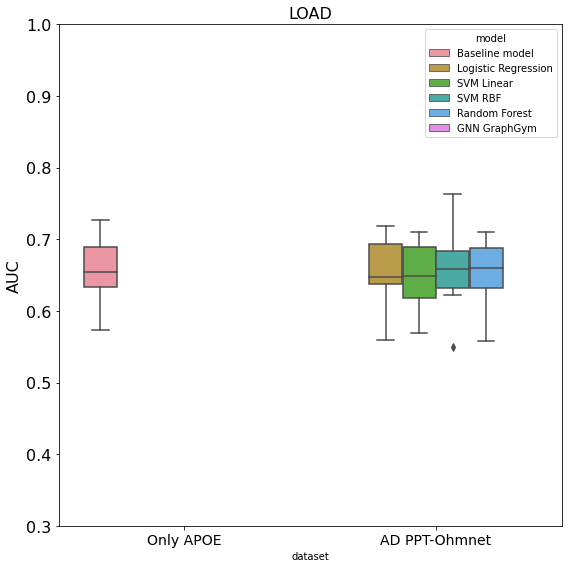

In [2]:
load_nonGNN = pd.read_csv('results/2022_03_nonGNN_models_LOAD.csv', index_col='fold')
# load_GNN    = pd.read_csv('results/2022_03_networks_LOAD.csv', index_col='fold')
load_bas    = pd.read_csv('results/2022_03_baseline_models_LOAD.csv',  index_col='fold')

load_all = pd.concat([load_nonGNN, load_bas])
boxplot_comparison_models('LOAD', load_all, 'auc', 'LOAD')

In [3]:
pvalues_bas_load, pvalues_ran_load = statistics(load_all)

Against baseline:
( ) 5.0101e-01 AD PPT-Ohmnet - SVM RBF
( ) 5.9103e-01 AD PPT-Ohmnet - Logistic Regression
( ) 5.9751e-01 AD PPT-Ohmnet - Random Forest
( ) 6.9812e-01 AD PPT-Ohmnet - SVM Linear
( ) nan AD PPT-Ohmnet - GNN GraphGym
( ) nan AD PPT-Ohmnet no APOE - Logistic Regression
( ) nan AD PPT-Ohmnet no APOE - SVM Linear
( ) nan AD PPT-Ohmnet no APOE - SVM RBF
( ) nan AD PPT-Ohmnet no APOE - Random Forest
( ) nan AD PPT-Ohmnet no APOE - GNN GraphGym

Against random:
(*) 2.0959e-09 AD PPT-Ohmnet - Random Forest
(*) 3.8991e-09 AD PPT-Ohmnet - SVM Linear
(*) 7.6678e-09 AD PPT-Ohmnet - Logistic Regression
(*) 2.5141e-08 AD PPT-Ohmnet - SVM RBF
( ) nan AD PPT-Ohmnet - GNN GraphGym
( ) nan AD PPT-Ohmnet no APOE - Logistic Regression
( ) nan AD PPT-Ohmnet no APOE - SVM Linear
( ) nan AD PPT-Ohmnet no APOE - SVM RBF
( ) nan AD PPT-Ohmnet no APOE - Random Forest
( ) nan AD PPT-Ohmnet no APOE - GNN GraphGym
